## Monte Carlo Simulation
This personal monte carlo project was developed in review of the HBS case Marsh & McLennan (A) revised in August 1992. 

In this simulation, we evaluate two aircraft hull insurance and make recommendations for which one is more cost-effective relative within a wide range of loss-scenarios over 10,000 simulation runs. Two plans under consideration are:

**(1) Loss Conversion Plan (LCP)** which has the following features:
- Annual premium calculated as 135% of incurred losses subject to:
    - max. annual rate of $1.05 per $100 insured value
    - min. annual rate of $.50 per $100 insured value
- Incentive credit calculated as 
    - 10% x (Tot. 3-yr premiums – Tot. 3-yr losses) provided plan runs for full 3-year term and total 3-year premiums > total 3-year losses

**(2) Profit Commission Plan (PCP)** which has the following features:
- Annual premium calculated as Losses plus $.25 per $100 insured subject to max. annual premium of 1% of insured value
- Incentive credit calculated as:
    - Tot. 3-yr premiums *less* Tot.3-yr losses + ($0.2 per $100 insured value/year x 3 years) if any excess exists
 
For the average industry crash-rate, we use findings from FAA research report between 9167 and 1968. During this period of time, 15,660,000 “equivalent hours” were recorded, with total losses of jet aircraft numbering 10. This translates to a crash rate of 0.006424 or 0.64%.

Plane insured value information is captured from the case. 

This is an example of a business planning and optimization problem that must take into account risk and uncertainty as we actually should.


In [51]:
import random
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
# create dataset of plane models, counts and book/insured values
plane_data = pd.read_excel("marsh_data.xls")
plane_data

,Aircraft,No of planes,Plane value (book),Plane value (insured)
0,DC-8-61,17,8709000,9000000
1,DC-8-63,2,11100000,11300000
2,DC-9-14,15,3310000,3400000
3,DC-9-21,14,2772000,3000000
4,DC-9-3,62,3825000,3900000
5,DC-9-31,5,3825000,3900000
6,720,15,2455000,3200000
7,727,50,3854000,4200000
8,727-225,1,6092225,6200000
9,727-QC,25,5710000,5900000


In [53]:
TOTAL_INS_VAL = (plane_data['Plane value (insured)'] * plane_data['No of planes']).sum()
TOTAL_INS_VAL

941600000

In [54]:
data_dict = plane_data.to_dict()
data_dict

{'Aircraft': {0: 'DC-8-61',
  1: 'DC-8-63',
  2: 'DC-9-14',
  3: 'DC-9-21',
  4: 'DC-9-3',
  5: 'DC-9-31',
  6: 720,
  7: 727,
  8: '727-225',
  9: '727-QC'},
 'No of planes': {0: 17,
  1: 2,
  2: 15,
  3: 14,
  4: 62,
  5: 5,
  6: 15,
  7: 50,
  8: 1,
  9: 25},
 'Plane value (book)': {0: 8709000,
  1: 11100000,
  2: 3310000,
  3: 2772000,
  4: 3825000,
  5: 3825000,
  6: 2455000,
  7: 3854000,
  8: 6092225,
  9: 5710000},
 'Plane value (insured)': {0: 9000000,
  1: 11300000,
  2: 3400000,
  3: 3000000,
  4: 3900000,
  5: 3900000,
  6: 3200000,
  7: 4200000,
  8: 6200000,
  9: 5900000}}

In [55]:
plane_data['Aircraft'] = plane_data['Aircraft'].astype(str) # convert plane model types to strings to take care of integer models e.g. 727

In [56]:
fleet = plane_data["No of planes"].sum() # total planes in fleet

In [57]:
plane_data['pval'] = plane_data['No of planes'] / fleet # plane model proportions of total fleet


In [58]:
# create a dictionary containing all required information for each plane model
info_dict = {}

for idx in range(plane_data.shape[0]):
    info_dict[str(plane_data.loc[idx, 'Aircraft'])] = (plane_data.loc[idx, 'No of planes'], plane_data.loc[idx, 'Plane value (insured)'],
                                                    plane_data.loc[idx, 'pval'])
info_dict

{'DC-8-61': (17, 9000000, 0.0825242718446602),
 'DC-8-63': (2, 11300000, 0.009708737864077669),
 'DC-9-14': (15, 3400000, 0.07281553398058252),
 'DC-9-21': (14, 3000000, 0.06796116504854369),
 'DC-9-3': (62, 3900000, 0.30097087378640774),
 'DC-9-31': (5, 3900000, 0.024271844660194174),
 '720': (15, 3200000, 0.07281553398058252),
 '727': (50, 4200000, 0.24271844660194175),
 '727-225': (1, 6200000, 0.0048543689320388345),
 '727-QC': (25, 5900000, 0.12135922330097088)}

In [59]:
# create a function to get the number of losses per year
hours, crashes = 15660000, 10 # per FAA research report
hour_per_plane = 10060 # From the case, this is the average flight hours per plane in fleet
fleet_hours = fleet * hour_per_plane
fleet_crashes = (fleet_hours / hours) * crashes
crash_rate = fleet_crashes / fleet
crash_rate

0.006424010217113665

In [60]:
# create function to calculate number of crashes in a year
def crash_count(fleet, rate):
    """
    returns number of crashes in a a year based on binomial
    distribution parameters
    """
    return np.random.binomial(fleet, rate)

In [61]:
def plane_type(num_crashes):
    """
    given a number of crashes, produces the plane 
    types for each crash count
    """
    crash_info = {}
    plane_array = np.random.multinomial(num_crashes, plane_data['pval'])

    plane_idx = plane_array.nonzero() # get the index of non-zero elements i.e., plane models which crashed
    # populate dictionary with plane type and number of crashes
    for elem in plane_idx[0]:
        crash_info[plane_data['Aircraft'][elem]] = plane_array[elem]


    return crash_info

In [63]:
def losses(crash_info, low=500000, high=1000000):
    """
    takes a dictionary of crashes plane models 
    and crash count for each model and gives the loss
    """
    total_loss = 0

    for key, value in crash_info.items():
        insured_val = info_dict[key][1]
        total_loss += insured_val * value + np.random.uniform(low, high)
    
    return total_loss

In [64]:
def lcp_premium(loss, min_rate=0.5, max_rate=1.05, percent=1.35, tot_val_insured=TOTAL_INS_VAL):
    """
    Computes the premium based on the loss value
    for loss conversion plan
    """
    min_rate = min_rate
    max_rate = max_rate
    percent = percent
    max_premium = max_rate * tot_val_insured / 100
    min_premium = min_rate * tot_val_insured / 100
    raw_premium = percent * loss

    if raw_premium < min_premium:
        return min_premium
    elif raw_premium < max_premium:
        return raw_premium
    else:
        return max_premium

In [65]:
def lcp_credit(total_premium, total_losses):
    """
    calculates incentive credit for lcp
    based on total losses
    """
    return max(0, 0.1*(total_premium - total_losses))
    

In [66]:
def pcp_premium(loss, tot_val_insured=TOTAL_INS_VAL, rate=0.25):
    """
    Computes the premium based on the loss value
    for profit commission plan
    """
    max_premium = tot_val_insured * 0.01
    rate = rate

    return min(max_premium, loss + rate * max_premium)




In [67]:
def pcp_credit(total_premium, total_losses, years=3):
    """
    calculates incentive credit for pcp
    based on total losses
    """ 
    rate = 0.2
    value_per_100USD = TOTAL_INS_VAL * 0.01
    return max(0, total_premium - (rate * value_per_100USD * years + total_losses)) 

In [68]:
def run_simulation(fleet=fleet, rate=crash_rate, trials=10000, years=3, seed=100):
    """
    Run the LCP simulation
    """
    lcp_costs = np.array([])
    pcp_costs = np.array([])
    loss_data = np.array([])

    for dummy in range(trials):
        # get the losses for each year and then total them to get credit and final losses
        annual_loss = np.array([])
        lcp_annual_premium = np.array([])
        pcp_annual_premium = np.array([])

        for dummy_idx in range(years):
            crashes = crash_count(fleet, rate) # get the number of crashes
            planes = plane_type(crashes) # get the type of planes involved in the crashes
            loss = losses(planes)
            annual_loss = np.append(annual_loss, loss)
            # compute premiums for LCP & PCP plans
            lcp_annual_premium = np.append(lcp_annual_premium, lcp_premium(loss))
            pcp_annual_premium = np.append(pcp_annual_premium, pcp_premium(loss))

        
        # compute total losses and premiums for the 3 years
        tot_losses = annual_loss.sum()
        tot_lcp_premium = lcp_annual_premium.sum()
        tot_pcp_premium = pcp_annual_premium.sum()

        loss_data = np.append(loss_data, tot_losses)
        lcp_incentive_credit = lcp_credit(tot_lcp_premium, tot_losses) # get the incentive credit after 3 years
        pcp_incentive_credit = pcp_credit(tot_pcp_premium, tot_losses)

        #calculate the cost for that 3-year period for both plans
        lcp_cost = tot_lcp_premium - lcp_incentive_credit
        pcp_cost = tot_pcp_premium - pcp_incentive_credit

        # add these values to the costs per simulation
        lcp_costs = np.append(lcp_costs, lcp_cost)
        pcp_costs = np.append(pcp_costs, pcp_cost)
    
    return lcp_costs.mean(), pcp_costs.mean(), loss_data, lcp_costs, pcp_costs # at the end of the simulation trial runs 

In [69]:
test1 = run_simulation()
test1

(21962654.695870813,
 20239790.768083073,
 array([ 8670491.94486139,  4881296.5074751 , 30043743.35089404, ...,
        20859679.26978647, 14347111.89410077, 40056074.45054787]),
 array([15638896.90749272, 14893304.90732976, 19302800.        , ...,
        19747362.52650164, 18807231.18941008, 24481600.        ]),
 array([14320091.94486139, 10530896.5074751 , 14124000.        , ...,
        17940712.9825938 , 14124000.        , 21186000.        ]))

In [70]:
# FINAL FUNCTION
# create a plot function here that will make the results into a pandas table and then do a count of times LCP > PCP
# out of N trials and then give the counts and then make plots of pdf and cdf

def show_results(simulation_result):
    """
    Takes the output of the simulation and returns
    proportion of times that the the PCP plan is higher
    than the LCP plan, as well as the expected value of
    each of the plans

    input: tuple of elements: mean LCP cost, mean PCP cost,
                            annual total losses, LCP costs, PCP costs
    """
    # get both the pcp and lcp plans into a dataframe
    data_frame = pd.DataFrame({'Losses': simulation_result[2], 'LCP_costs': simulation_result[3], 'PCP_costs': simulation_result[4]})
    trials = data_frame.shape[0]
    
    # get count and proportion times LCP > PCP
    lcp_higher_count = np.where(data_frame['LCP_costs'] > data_frame['PCP_costs'], 1, 0).sum()
    lcp_higher_proportion = lcp_higher_count / trials
    pcp_higher_proportion = 1 - lcp_higher_proportion
    
    # get the expected value of both plans and package all results in a dictionary
    lcp_mean = simulation_result[0]
    pcp_mean = simulation_result[1]
    result_dict = {'LCP Expected Value': lcp_mean,
                    'PCP Expected Value': pcp_mean,
                    'LCP Higher perc. of Trials': str(np.round(lcp_higher_proportion * 100, 2))+"%",
                    'PCP Higher perc. of Trials': str(np.round(pcp_higher_proportion * 100, 2))+"%",
                    'Simulation Runs': trials}
    
    # plot pdf and cdf plots for both plans 
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    # fig, ax1 = plt.subplots()
    probs = np.arange(trials) / float(trials)
    fig.set_size_inches(15, 7)
    ax1.hist(simulation_result[3], bins=20)
    ax1.set_title("LCP costs distribution")
    ax2.plot(np.sort(simulation_result[3]), probs)
    ax2.set_title("LCP CDF")
    ax3.hist(simulation_result[4], bins=20)
    ax3.set_title("PCP costs distribution")
    ax4.plot(np.sort(simulation_result[4]), probs)
    ax4.set_title("PCP CDF")



    return result_dict, data_frame.describe()

{'LCP Expected Value': 21962654.695870813,
 'PCP Expected Value': 20239790.768083073,
 'LCP Higher perc. of Trials': '80.37%',
 'PCP Higher perc. of Trials': '19.63%',
 'Simulation Runs': 10000}

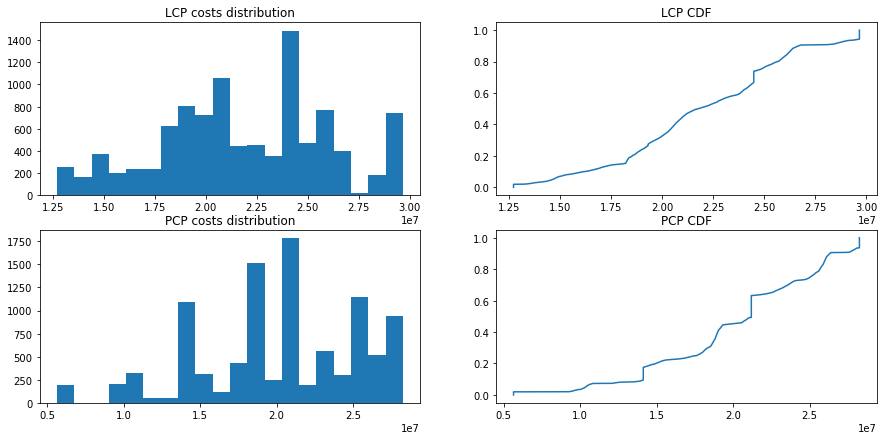

In [71]:
display = show_results(test1)
display[0]

In [72]:
display[1]

,Losses,LCP_costs,PCP_costs
count,1.000000e+04,1.000000e+04,1.000000e+04
mean,2.082127e+07,2.196265e+07,2.023979e+07
std,1.072262e+07,4.184826e+06,5.295624e+06
min,0.000000e+00,1.271160e+07,5.649600e+06
25%,1.337666e+07,1.913185e+07,1.760754e+07
50%,1.962941e+07,2.175552e+07,2.118600e+07
75%,2.759718e+07,2.479405e+07,2.503551e+07
max,7.391984e+07,2.966040e+07,2.824800e+07


**Conclusion:**

Based on the analysis above and the visuals, we see that the LCP option had a higher expected value than that of the PCP - $21.96MM vs. $20.24MM. 

Moreso, the LCP cost to the company was higher in over 8k of the 10k simulations of possible outcomes, while the PCP was higher than the LCP in slightly less than 2k of the 10k simulations. 

It would be prudent for the business to go with the PCP insurance option for its fleet.